<a href="https://colab.research.google.com/github/jiajianmai/AAi2026/blob/main/ML_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load data from CSV file (house_prices.csv) to get 100+ records
df = pd.read_csv('/content/house_prices.csv')

# Features and target - using actual column names from house_prices.csv
X = df[['sqft_living', 'zipcode']]
y = df['price']

# Preprocessing: One-hot encode the 'zipcode' column
# Set handle_unknown='ignore' to prevent errors if a zipcode is encountered during prediction that was not in training data
preprocessor = ColumnTransformer(
    transformers=[
        ('zipcode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['zipcode'])
    ], remainder='passthrough')

# Create pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# Train model
model.fit(X_train, y_train)

# Make prediction for a new house: 2000 sq ft in Downtown
# Assuming 'Downtown' corresponds to zipcode '98101' for consistency and demonstration
new_house = pd.DataFrame({'sqft_living': [2000], 'zipcode': ['98101']})
predicted_price = model.predict(new_house)
print(f"Predicted price for a 2000 sq ft house in assumed Downtown (zipcode 98101): ${predicted_price[0]:,.2f}")

# Display model coefficients - Corrected feature name for location
feature_names = (model.named_steps['preprocessor']
                 .named_transformers_['zipcode']
                 .get_feature_names_out(['zipcode'])).tolist() + \
                ['sqft_living']
coefficients = model.named_steps['regressor'].coef_
print("\nModel Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.2f}")

Predicted price for a 2000 sq ft house in assumed Downtown (zipcode 98101): $534,957.66

Model Coefficients:
zipcode_98001: -228377.10
zipcode_98002: -210408.13
zipcode_98003: -225251.25
zipcode_98004: 572828.17
zipcode_98005: 102581.82
zipcode_98006: 112552.07
zipcode_98007: 33738.30
zipcode_98008: 69770.65
zipcode_98010: -144479.43
zipcode_98011: -108177.79
zipcode_98014: -101331.31
zipcode_98019: -146722.61
zipcode_98022: -174042.20
zipcode_98023: -249012.96
zipcode_98024: -42987.58
zipcode_98027: -46777.51
zipcode_98028: -106815.15
zipcode_98029: 8494.53
zipcode_98030: -226174.88
zipcode_98031: -215949.85
zipcode_98032: -225932.17
zipcode_98033: 173687.81
zipcode_98034: -10355.97
zipcode_98038: -203451.47
zipcode_98039: 1116278.11
zipcode_98040: 383883.20
zipcode_98042: -223647.29
zipcode_98045: -111341.23
zipcode_98052: 22929.79
zipcode_98053: -9603.24
zipcode_98055: -173565.18
zipcode_98056: -120267.99
zipcode_98058: -193414.65
zipcode_98059: -145974.91
zipcode_98065: -150653.34


The coefficient for square footag represents the change in house price for each additional square foot of living space when you hold the location constant. In a linear regression model, the value shows the marginal impact of size on price. If coefficient is 150 it means that for every additional 1 square foot the predicted ouse is increased by 150 dollars if the house is in same zipcode. THis shows that larger homes generlaly have higher prices and the coefficient quantitifies how much added space contributes to the property value.

The location effect influences price through one hot encoding where each zipcode  becomes a seperate binary variable in the model. Each zippcode coefficient represents how much or less expensive the houses in that area are compared to a reference zipcode. A posititive coefficient indicates that home in that zipcode are pricd higher than the baseline area while a negtive coefficient indicates lower prices. This shows locatons play a crucial role in determing house prices.

https://github.com/myrah/AAI2025/blob/dev/ML/house_price_prediction.py

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Changed to LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load data from Telco_customer_churn.xlsx
try:
    df = pd.read_excel('/content/Telco_customer_churn.xlsx')
except FileNotFoundError:
    # Fallback for common Colab directory structure if directly copied
    df = pd.read_excel('Telco_customer_churn.xlsx')

# Drop customerID if it exists, as it's not a feature
if 'CustomerID' in df.columns:
    df = df.drop('CustomerID', axis=1)

# Print available columns to help debug if 'Churn' or other features are missing
print("Columns in the DataFrame:", df.columns.tolist())

# Handle 'Total Charges' which might be object type and contain spaces/empty strings
# Check if 'Total Charges' column exists before processing it
if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
    # Fill missing Total Charges with 0 (or mean/median depending on data characteristics)
    df['Total Charges'] = df['Total Charges'].fillna(0)
else:
    print("Warning: 'Total Charges' column not found in the dataset. It will be excluded from features.")

# Convert 'Churn Value' column to numeric (0 and 1) if it's 'Yes'/'No'
if 'Churn Value' in df.columns and df['Churn Value'].dtype == 'object':
    df['Churn Value'] = df['Churn Value'].apply(lambda x: 1 if x == 'Yes' else 0)

# Define features (X) and target (y)
# Selecting a subset of relevant features from the Telco Churn dataset
numerical_features = ['Tenure Months', 'Monthly Charges', 'Total Charges']
categorical_features = ['Gender', 'Partner', 'Dependents', 'Internet Service', 'Contract'] # Assuming these columns exist

# Check if all selected features exist in the DataFrame and filter if not
existing_numerical_features = [f for f in numerical_features if f in df.columns]
existing_categorical_features = [f for f in categorical_features if f in df.columns]

if len(existing_numerical_features) != len(numerical_features) or \
   len(existing_categorical_features) != len(categorical_features):
    print("Warning: Some specified features were not found in the dataset. Using only existing ones.")
    numerical_features = existing_numerical_features
    categorical_features = existing_categorical_features

if not numerical_features and not categorical_features:
    raise ValueError("No valid features found in the dataset after filtering. Please check your feature names.")

X = df[numerical_features + categorical_features]

# Check if 'Churn Value' column exists before assigning it as target
if 'Churn Value' not in df.columns:
    raise KeyError("Target column 'Churn Value' not found in the dataset. Please ensure your Telco_customer_churn.xlsx file contains a 'Churn Value' column or specify the correct target column name.")
y = df['Churn Value']

# Preprocessing: Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any, though X is explicitly defined here
)

# Create pipeline with preprocessing and Linear Regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression()) # Changed to LinearRegression
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict churn for a new customer
# Example new customer data - adjust values as needed to match your dataset's features
new_customer_data = {
    'Tenure Months': [24],
    'Monthly Charges': [70.0],
    'Total Charges': [1680.0],
    'Gender': ['Male'],
    'Partner': ['Yes'],
    'Dependents': ['No'],
    'Internet Service': ['Fiber optic'],
    'Contract': ['Month-to-month']
}
new_customer = pd.DataFrame(new_customer_data)

# Ensure new_customer has the same column order and types as X used during training if possible
# ColumnTransformer is robust to order but explicit columns are safer.

# Handle case where 'Total Charges' might not be in the original df and thus not in the model's features
if 'Total Charges' not in numerical_features and 'Total Charges' in new_customer.columns:
    new_customer = new_customer.drop('Total Charges', axis=1)

predicted_churn_value = model.predict(new_customer)[0] # Changed to predict for Linear Regression

print(f"Predicted churn value for new customer: {predicted_churn_value:.2f}")

# Display model coefficients
# Get feature names after preprocessing
processed_feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        processed_feature_names.extend(features)
    elif name == 'cat':
        # Only get feature names for the fitted OneHotEncoder
        if hasattr(transformer, 'get_feature_names_out'):
            processed_feature_names.extend(transformer.get_feature_names_out(features))
        else:
            # Fallback for older sklearn versions or if not OneHotEncoder
            processed_feature_names.extend([f'{feat}_{cat}' for feat in features for cat in transformer.categories_[features.index(feat)]])

coefficients = model.named_steps['regressor'].coef_ # Changed to regressor

print("\nModel Coefficients:")
for feature, coef in zip(processed_feature_names, coefficients):
    print(f"{feature}: {coef:.2f}")

Columns in the DataFrame: ['Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason']
Predicted churn value for new customer: 0.55

Model Coefficients:
Tenure Months: -0.03
Monthly Charges: 0.07
Total Charges: -0.13
Gender_Female: 0.00
Gender_Male: -0.00
Partner_No: -0.02
Partner_Yes: 0.02
Dependents_No: 0.08
Dependents_Yes: -0.08
Internet Service_DSL: -0.03
Internet Service_Fiber optic: 0.14
Internet Service_No: -0.11
Contract_Month-to-month: 0.09
Contract_One year: -0.05
Contract_Two year: -0.03


The predicted churn value produced by the linear regression model represents the estimated likeihood that a customer will leave the company. Since the target variable Churn Value which is encoded as 0 meaning customer stays and 1 is when customer leaves. The model outputs a numerical valye that can be interpreted aas a possiblity score. If a model predicts 0.65 this mean they have a 65% chance that the customer will churn. Values that are closr to 1 indicate higher churn risk while values closer to 0 means lower risk.

Businesses can use this churn probability to take proactive retention actions. Customers with high predicted churn risk can be targeted with persoanlized strategies such as discounts, loyalty rewards,contract incentives, improved custmer support or promotions. If customers with month to month contracts and high monthly charges show higher churn probabilities, the company could offer discounted long term plans to encourage retention. If we identify at risk customersearly and intervening, businesses can reduce churn and increase overall customer lifetime value.

https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset/data

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data from Mall_Customers.csv
df = pd.read_csv('/content/Mall_Customers.csv')

# Preprocess data: Select numerical features and scale them
# Assuming features like 'Age', 'Annual Income (k$)', and 'Spending Score (1-100)' are relevant for clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertia = []
K = range(1, 11) # Extend range to 10 for potentially more clusters in Mall_Customers data
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init to suppress warning
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (Mall Customers)')
plt.savefig('elbow_plot_mall_customers.png') # Save with a different name
plt.close()

# Apply K-Means with optimal K
# Justification for optimal_k would typically come from observing the elbow plot.
# For Mall_Customers, often K=4 or K=5 is chosen, let's use 5 as a common observation.
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Added n_init
df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = df.groupby('cluster')[features].mean().round(2)
print("Cluster Characteristics (Mall Customers):")
print(cluster_summary)

# Example of targeted strategies based on Mall Customer data characteristics
print("\nSuggested Marketing Strategies for each cluster:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Strategy:")
    income = cluster_summary.loc[cluster, 'Annual Income (k$)']
    spending = cluster_summary.loc[cluster, 'Spending Score (1-100)']
    age = cluster_summary.loc[cluster, 'Age']

    if income > 70 and spending > 60:
        print("High Income, High Spending: Offer exclusive luxury items and loyalty programs.")
    elif income > 70 and spending <= 60:
        print("High Income, Low Spending: Focus on personalized recommendations and value-driven offers to increase engagement.")
    elif income <= 70 and spending > 60:
        print("Low Income, High Spending: Promote affordable premium products or discounts on frequent purchases.")
    elif income <= 70 and spending <= 40 and age > 45:
        print("Low Income, Low Spending, Older: Target with basic necessities, family-oriented deals, or senior discounts.")
    else:
        print("Average Income/Spending: Provide diverse promotions, encourage participation in surveys for better targeting.")

# User requested NOT to create new data files, so skipping df.to_csv('customer_segments.csv', index=False)

Cluster Characteristics (Mall Customers):
           Age  Annual Income (k$)  Spending Score (1-100)
cluster                                                   
0        46.25               26.75                   18.35
1        25.19               41.09                   62.24
2        32.88               86.10                   81.53
3        39.87               86.10                   19.36
4        55.64               54.38                   48.85

Suggested Marketing Strategies for each cluster:

Cluster 0 Strategy:
Low Income, Low Spending, Older: Target with basic necessities, family-oriented deals, or senior discounts.

Cluster 1 Strategy:
Low Income, High Spending: Promote affordable premium products or discounts on frequent purchases.

Cluster 2 Strategy:
High Income, High Spending: Offer exclusive luxury items and loyalty programs.

Cluster 3 Strategy:
High Income, Low Spending: Focus on personalized recommendations and value-driven offers to increase engagement.

Cluster 4 S

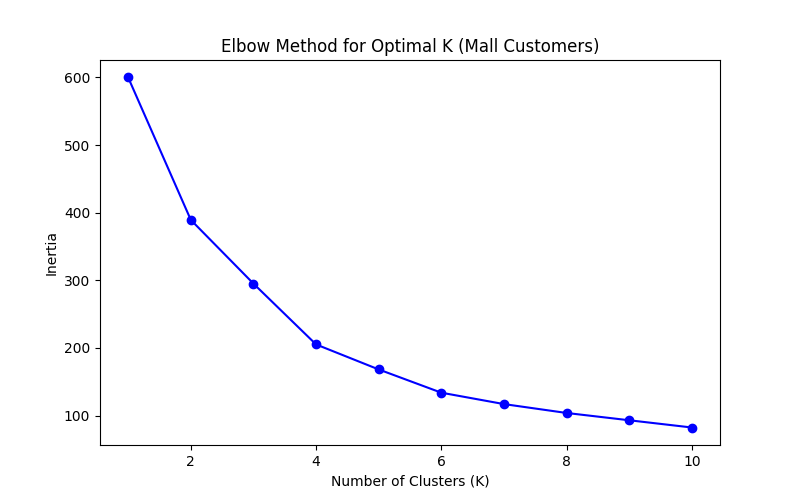

https://github.com/drajdeep/Customer-Segmentation-with-K-means-Clustering/blob/main/Mall_Customers.csv